In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from astropy.coordinates import Angle
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128
import itertools

In [3]:
const_c = c.value   # speed of light [m/s]
frequency = 93.7e9              # observing frequency [Hz]
wavelength = const_c/frequency # receiving wavelength [metres]

# Funciones

In [4]:
#función casa sumutil.py

def long2xyzbroad(coords):
        """
        Returns the nominal ITRF (X, Y, Z) coordinates [m] for a point at
        geodetic latitude and longitude [radians] and elevation [m].
        The ITRF frame used is not the official ITRF, just a right
        handed Cartesian system with X going through 0 latitude and 0 longitude,
        and Z going through the north pole.
        orig. source: http://www.oc.nps.edu/oc2902w/coord/llhxyz.htm
        """

        lat = np.radians(coords[:,0])
        lon = np.radians(coords[:,1])
        elevation = coords[:,2]


        er=6378137.0
        rf=298.257223563

        f=1./rf
        esq=2*f-f**2
        nu=er/np.sqrt(1.-esq*(np.sin(lat))**2)

        x=(nu+elevation)*np.cos(lat)*np.cos(lon)
        y=(nu+elevation)*np.cos(lat)*np.sin(lon)
        z=((1.-esq)*nu+elevation)*np.sin(lat)

        return np.column_stack((x,y,z))

In [5]:
#función profe
def _earthlocation_to_altaz(location, reference_location):
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [6]:
#función profe
def earth_location_to_local(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    return altaz.cartesian.xyz

In [7]:
def calc_R(H,dec):
    
    """
    function to calculate rotation matrix
    """
    
    R = [[np.sin(H), np.cos(H), 0],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec)]]
    
    return np.array(R)

In [8]:
# Dado la rotación de la tierra, el objeto se "desplaza" en el cielo, por lo tanto se utiliza el
# ángulo horario y declinación para seguir su posición en el cielo

def calc_RR(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [9]:
def h(hObs, gradDec, t_muestreo):

    """ 
    Cambia la duración de la observación a X horas
    Muestreo cada 0.1 hrs - 6 min
       """

    observacion_grados = hObs * 15.0
    HA = np.arange(-np.radians(observacion_grados), np.radians(observacion_grados), np.radians(t_muestreo/60))  # [radianes]
    dec = np.radians(gradDec)
    return HA, dec

In [11]:
#antiguo pero modifcado con nuevo pixel-uv
def grid_sampling(piximg, max_B, coverage):
    """ 
    piximg: cantidad de pixeles de la imagen modelo, tiene que ser nxn
    max_B: baseline mas largo
    uvcoverage: array uv cobertura

       """
    sampling = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    uvgrid = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    uvgrid2 = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    min_lambda=wavelength #minima longitud de onda lambda
    delta_x = (min_lambda / max_B) / 7
    delta_u = 1 / ((piximg * delta_x) + 0.00000001)

    u_pixel2 = np.floor(0.5 + coverage[:, 0] / delta_u + piximg / 2).astype(int)
    v_pixel2 = np.floor(0.5 + coverage[:, 1] / delta_u + piximg / 2).astype(int)

    """ for i in range(coverage.shape[0]):
      u_pixel = int(np.floor(0.5 + coverage[i,0]/delta_u) + piximg/2)
      v_pixel = int(np.floor(0.5 + coverage[i,1]/delta_u) + piximg/2)
      uvgrid2[v_pixel, u_pixel] += 1.0 + 1j*0.0 """
      
    np.add.at(uvgrid, (v_pixel2, u_pixel2), 1.0 + 1j*0.0)
    # S(u,v) = 1 otro caso S=0
    """ sampling = np.zeros_like(uvgrid)
    posiciones_con_valores = uvgrid != 0
    sampling[posiciones_con_valores] = 1 """
    sampling[v_pixel2, u_pixel2] = 1.0
    return sampling, uvgrid, uvgrid2


In [12]:
def baselines(xyz):
    XYZ_baselines = []                                                                  
    for i in range(len(xyz)):                                                         
        for j in range(i+1,len(xyz)):
            XYZ_baselines.append(np.subtract(xyz[i], xyz[j])) # (u,v)
            XYZ_baselines.append(np.subtract(xyz[j], xyz[i])) # (-u,-v)     

    XYZ_baselines = np.array(XYZ_baselines)
    return XYZ_baselines

In [13]:
def new_base(xyz):

    antenna_id = np.arange(0, len(xyz[:,0])) #cantidad de antenas
    antenna_pair_combinations = np.fromiter(itertools.chain(*itertools.combinations(antenna_id, 2)), dtype=int).reshape(-1,2) #combinaciones

    baselines = np.vstack([xyz[antenna_pair_combinations[:,0]] - xyz[antenna_pair_combinations[:,1]], 
                       xyz[antenna_pair_combinations[:,1]] - xyz[antenna_pair_combinations[:,0]]]) # se generan los baselines

    return baselines

In [14]:
def coverage(baselines, HA, dec):
    UV_coverage=[]
    for i in range(len(HA)):
        for j in range(len(baselines)):
            R = calc_R(HA[i],dec)
            UV_coverage.append(np.dot(R, baselines[j]))
    
    UV_coverage = np.array(UV_coverage)
    return UV_coverage

In [15]:
def new_cover(baseline, HA, dec):
    R = calc_RR(HA, dec).transpose(2,0,1)
    coverage = np.dot(R, baseline.T)/wavelength #se divide por la longitud de onda
    #transpuesta para que no sean puntos (u,v) sobre un mapa sino que se vea como dado la rotación de la tierra se van generando elipses
    #caso contrario solo serían circulos
    return coverage

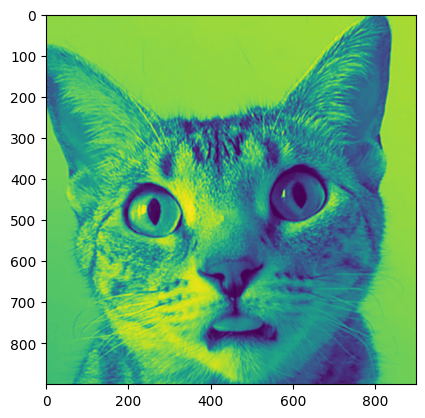

In [16]:
# Cargar la imagen como fuente de luz
image = cv2.imread('cat1.jpg',0)
pix = image.shape[0]
plt.imshow(image)
plt.show()

In [17]:
fft = np.fft.fft2(image)
ffts = np.fft.fftshift(fft)
ff = np.abs(np.log(ffts))

# Ejemplo 1

In [119]:
data = [
    [-41.464183, -72.919694, 100],
    [-41.464507, -72.919898, 100],
    [-41.464263, -72.919739, 100],
    [-41.464304, -72.919764, 100],
    [-41.464342, -72.919789, 100],
    [-41.464387, -72.919819, 100],
    [-41.464424, -72.919843, 100],
    [-41.464469, -72.919870, 100],
    [-41.464507, -72.919898, 100]
]

data = np.array(data)

In [120]:
localxyz = long2xyzbroad(data)

In [123]:
# solo utilizar si el sistema de coordenadas que te entregan está en local tangent plane (ENU) (LOC en archivos CASA)
abc = EarthLocation.from_geodetic(data[:,1], data[:,0], data[:,2])
reference_location = EarthLocation.from_geodetic(-72.920166, -41.463874,100)
x, y, z = earth_location_to_local(abc, reference_location)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

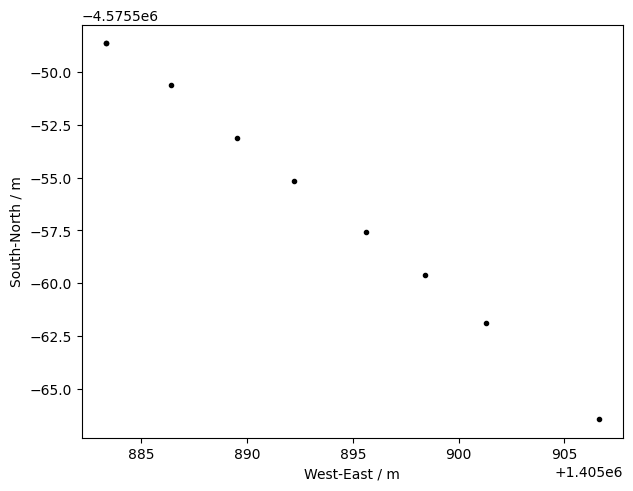

In [101]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(localxyz[:,0], localxyz[:,1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [124]:
stack = np.column_stack((x.value,y.value,z.value))

In [147]:
HA, dec = h(6,-26, 6)

In [148]:
cccc = baselines(localxyz)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

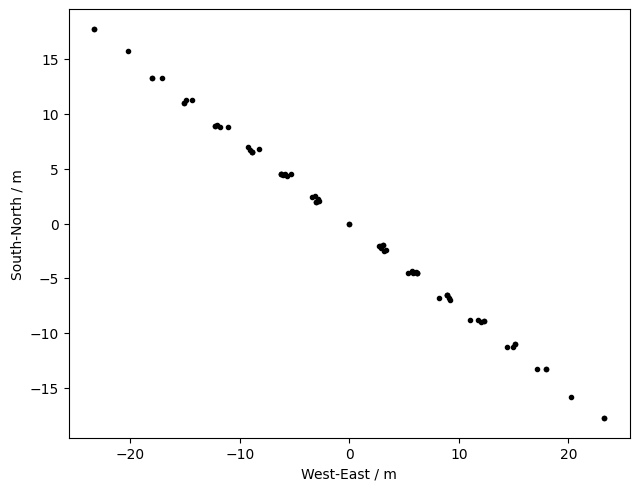

In [149]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(cccc[:,0], cccc[:,1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [150]:
#Antiguo - me refiero a realizar la reconstrucción sin tener en cuenta los cambios de como generar el uv-coverage
UV_coverageEj1 = coverage(baselines(stack), HA, dec)/wavelength

In [151]:
#Nuevo

N_UV_coverageEJ1 = new_cover(new_base(localxyz), HA, dec)

Text(0, 0.5, '$v\\ \\lambda$')

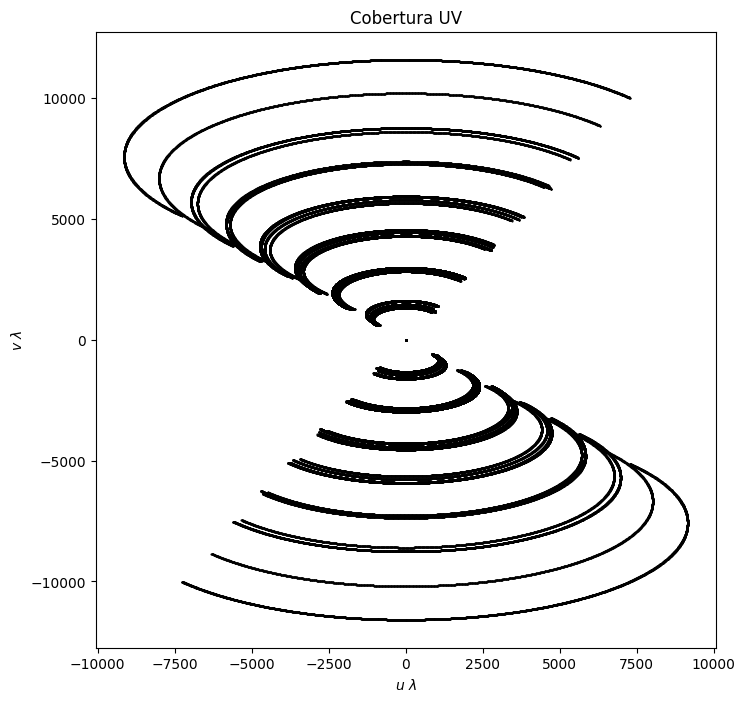

In [152]:
fig = plt.figure(figsize=(8,8))
plt.title("Cobertura UV")
plt.scatter(x=N_UV_coverageEJ1[:,0],y=N_UV_coverageEJ1[:,1], c="black", marker='.',s=1)
plt.xlabel(r'$u\ \lambda$')  # Usa 'r' antes de la cadena de texto para que Python la trate como raw string
plt.ylabel(r'$v\ \lambda$')

Text(0, 0.5, '$v\\ \\lambda$')

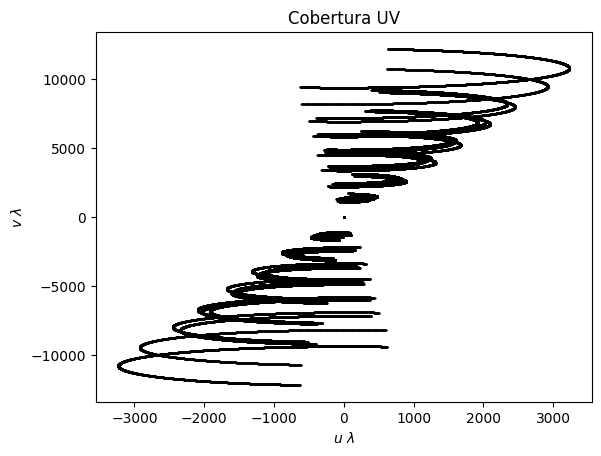

In [153]:
fig, ax = plt.subplots()
plt.title("Cobertura UV")
ax.scatter(UV_coverageEj1[:,0],UV_coverageEj1[:,1], c="black", marker='.', s=1)
ax.set_xlabel(r'$u\ \lambda$')  # Usa 'r' antes de la cadena de texto para que Python la trate como raw string
ax.set_ylabel(r'$v\ \lambda$')

In [27]:
""" plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) """

' plt.rcParams["animation.html"] = "jshtml"\nplt.rcParams[\'figure.dpi\'] = 150  \nplt.ioff()\nfig, ax = plt.subplots()\n\ndef animate(t):\n    plt.cla()\n    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")\n\nmatplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) '

In [154]:
#ocupo la misma funcion de grid y sampling para ambos
samplingEJ1, psf, psf3=grid_sampling(pix,np.max(np.abs(baselines(stack))), UV_coverageEj1)

In [155]:
new_samplingEJ1, psf, psf3=grid_sampling(pix,np.max(np.abs(new_base(stack))), N_UV_coverageEJ1)

In [156]:
psf2 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(psf)))
fft_norm = np.max(psf2.real)
psf2/= fft_norm

In [164]:
psf4 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(psf)))
fft_norm = np.max(psf4.real)
psf4/= fft_norm

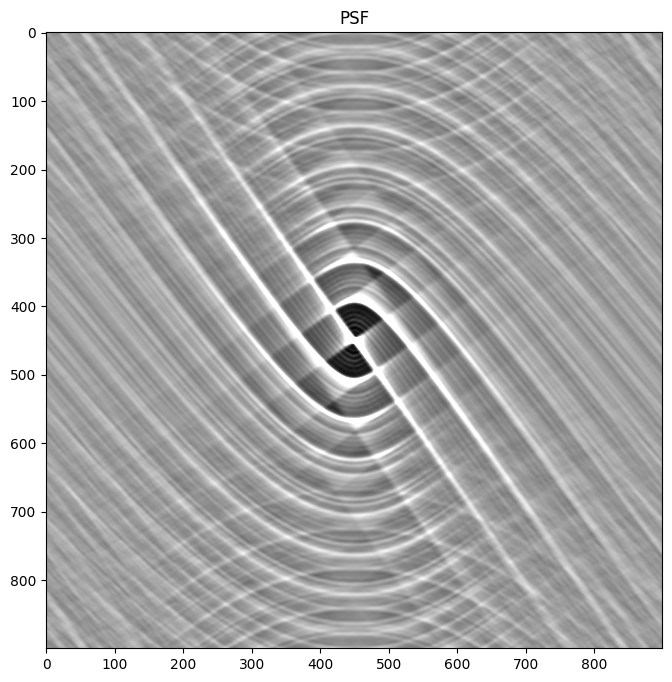

In [158]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('PSF')
plt.imshow(psf2.real, cmap='gray', vmax=0.1)

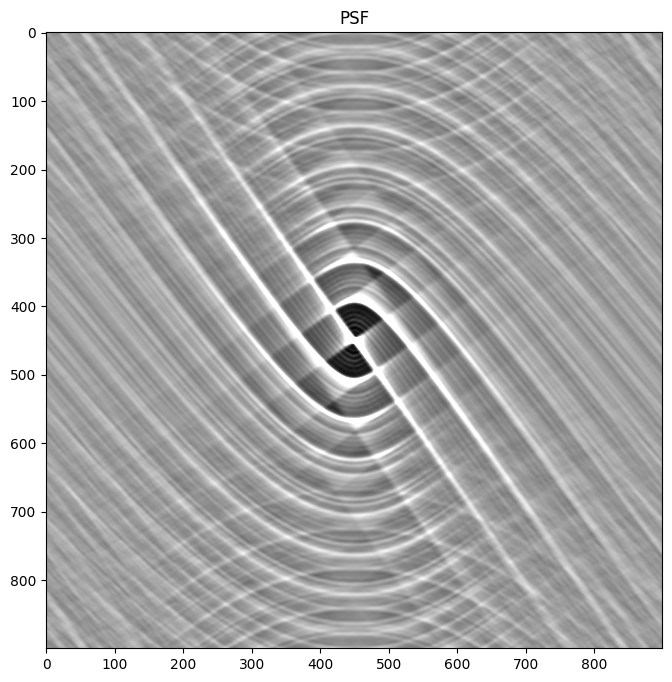

In [165]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('PSF')
plt.imshow(psf4.real, cmap='gray', vmax=0.1)

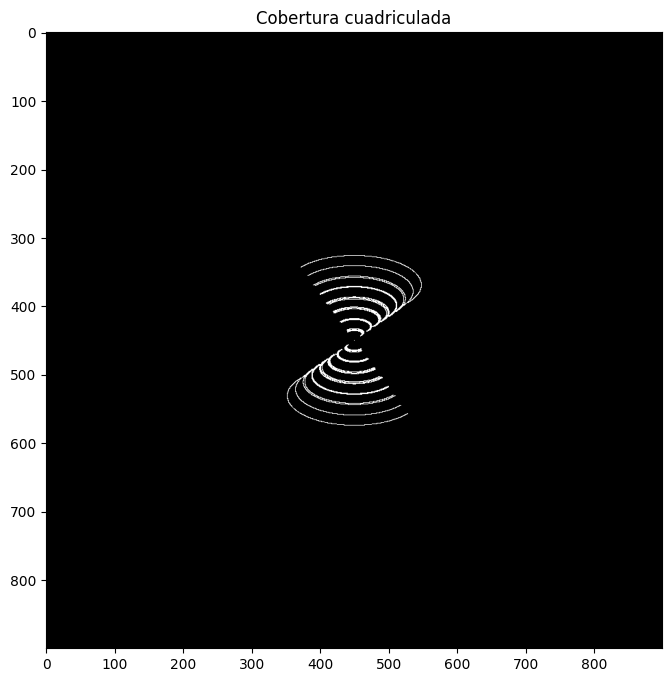

In [166]:
figure = plt.figure(figsize=(8, 8))
plt.subplot()
plt.title('Cobertura cuadriculada')
plt.imshow(new_samplingEJ1.real, cmap='gray')

In [167]:
obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ1)))

In [168]:
new_obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ1)))

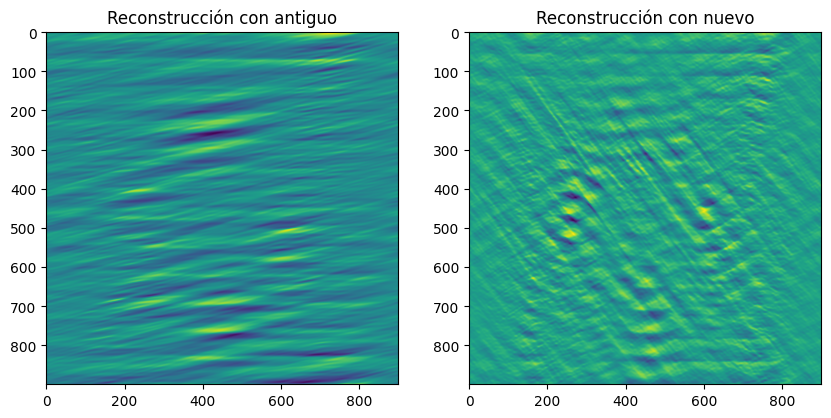

In [169]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ1)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ1)

# Ejemplo 2

In [18]:
posiciones = [
    (-41.483775, -72.859583, 100),
    (-41.482888, -72.859582, 100),
    (-41.481990, -72.859598, 100),
    (-41.481093, -72.859625, 100),
    (-41.480198, -72.859611, 100),
    (-41.484689, -72.860797, 100),
    (-41.484683, -72.861984, 100),
    (-41.484678, -72.863175, 100),
    (-41.484657, -72.864401, 100),
    (-41.484642, -72.865588, 100),
    (-41.485612, -72.859579, 100),
    (-41.486489, -72.859579, 100),
    (-41.487352, -72.859580, 100),
    (-41.488257, -72.859578, 100),
    (-41.489204, -72.859560, 100),
    (-41.484684, -72.858503, 100),
    (-41.484679, -72.857282, 100),
    (-41.484662, -72.856079, 100),
    (-41.484644, -72.854922, 100),
    (-41.484623, -72.853653, 100)
]
pos2 = np.array(posiciones)
reference = [-41.484687, -72.859583, 100]

In [19]:
dataEJ2 = long2xyzbroad(pos2)

In [22]:
# solo utilizar si el sistema de coordenadas que te entregan está en local tangent plane (ENU) (LOC en archivos CASA)
abc = EarthLocation.from_geodetic(pos2[:,1], pos2[:,0], pos2[:,2])
reference_location = EarthLocation.from_geodetic(reference[1], reference[0], 100)
x, y, z = earth_location_to_local(abc, reference_location)

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

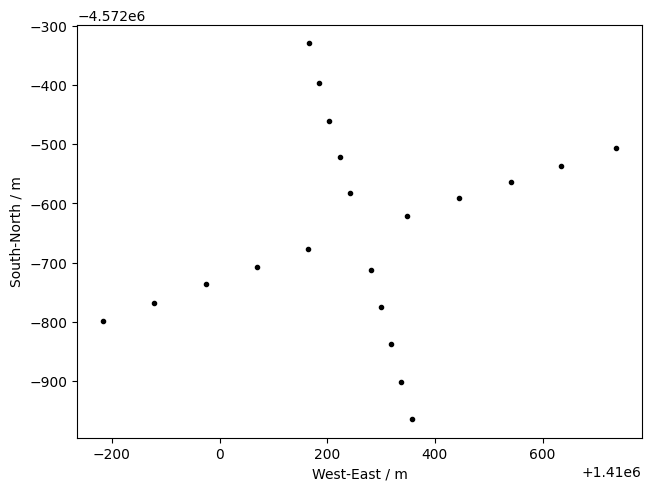

In [20]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(dataEJ2[:,0], dataEJ2[:,1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [23]:
ej2 = np.column_stack((x.value,y.value,z.value))

In [227]:
ppp = baselines(dataEJ2)

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

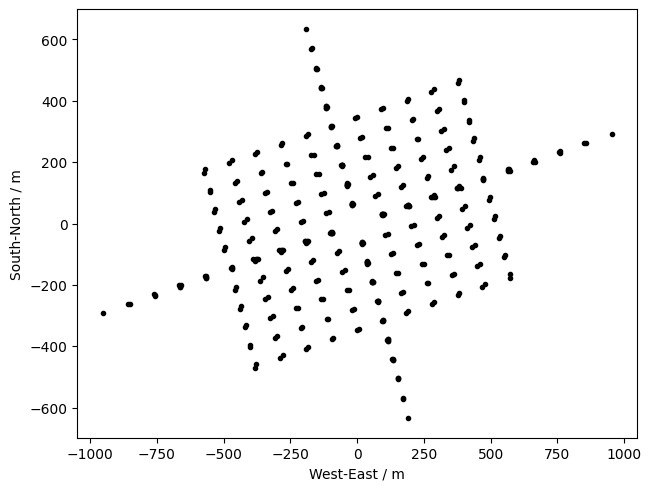

In [228]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(ppp[:,0], ppp[:,1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [25]:
# X horas de observación, Y declinación, Z tiempo de muestreo
HA, dec = h(3,45, 6)
UV_coverageEJ2 = coverage(baselines(ej2), HA, dec)/wavelength
N_UV_coverageEJ2 = new_cover(new_base(dataEJ2), HA, dec)

Text(0, 0.5, 'v (lambda)')

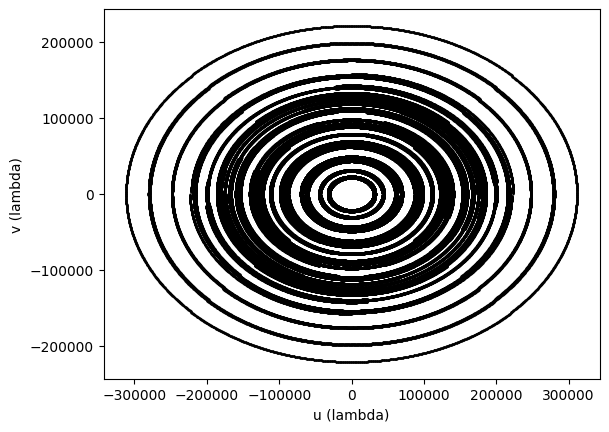

In [26]:
fig, ax = plt.subplots()
ax.scatter(UV_coverageEJ2[:, 0],UV_coverageEJ2[:,1], c="black", marker=".", s=1)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

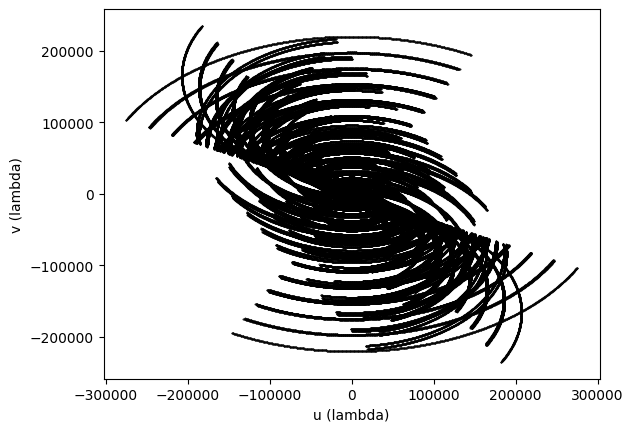

In [27]:
fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ2[:, 0],N_UV_coverageEJ2[:,1], c="black", marker=".", s=0.5)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [31]:
samplingEJ2, psf ,_=grid_sampling(900,np.max(np.abs(baselines(ej2))), UV_coverageEJ2)
new_samplingEJ2, psf2, _=grid_sampling(900,np.max(np.abs(new_base(ej2))), N_UV_coverageEJ2)

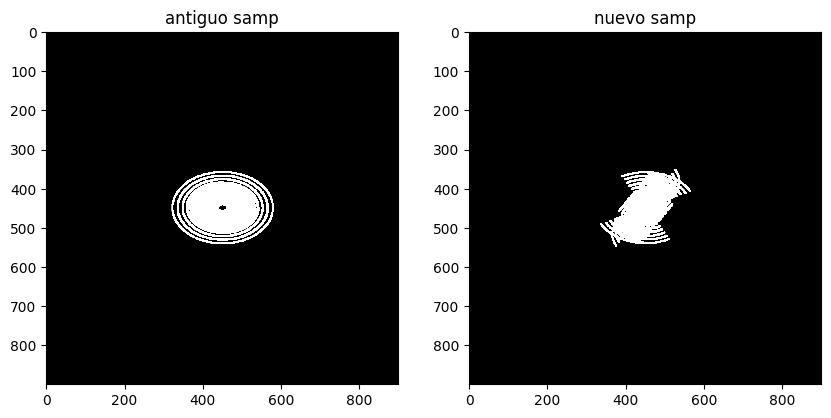

In [230]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('antiguo samp')
plt.imshow(samplingEJ2.real, cmap='gray', vmax=0.0005)
plt.subplot(122)
plt.title('nuevo samp')
plt.imshow(new_samplingEJ2.real, cmap='gray',vmax=0.0005)

In [32]:
obs_EJ2 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ2)))
new_obs_EJ2 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ2)))

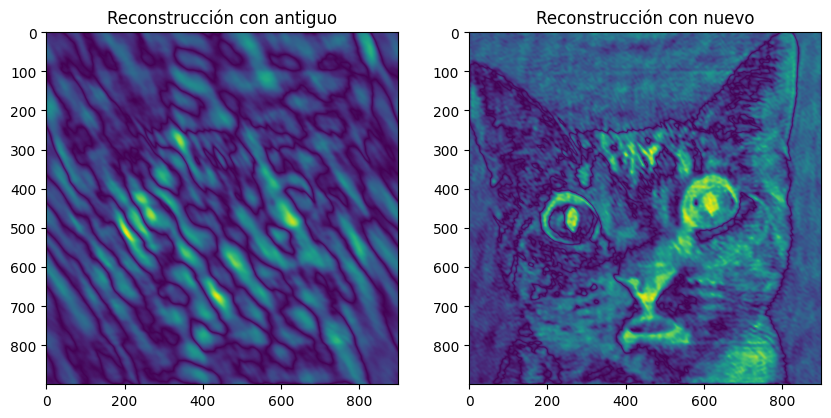

In [33]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ2)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ2)

# Ejemplo 3 VLA-D

Formas del UV-Coverage de acuerdo al siguiente PDF pag 84:
https://library.nrao.edu/public/collection/02000000000324.pdf

In [18]:
#posiciones configuración D VLA en coordenadas geograficas (WGS84) - no son exactas
# latitud, longitud, altitud

geoVLA = [[  34.07842625, -107.61828459, 2124.],
       [  34.07808908, -107.61824551, 2124.],
       [  34.07855437, -107.61787752, 2124.],
       [  34.07873509, -107.61831552, 2124.],
       [  34.07850582, -107.61873236, 2124.],
       [  34.07845388, -107.61744277, 2124.],
       [  34.07823558, -107.61685885, 2124.],
       [  34.0779916 , -107.6162074 , 2124.],
       [  34.07762727, -107.61540993, 2124.],
       [  34.07735044, -107.61453944, 2124.],
       [  34.07691797, -107.61358346, 2124.],
       [  34.0765645 , -107.61250526, 2124.],
       [  34.07835685, -107.61913043, 2124.],
       [  34.07807862, -107.61964473, 2124.],
       [  34.07772367, -107.62027238, 2124.],
       [  34.07729173, -107.62099514, 2124.],
       [  34.07685974, -107.62178528, 2124.],
       [  34.07636212, -107.62269102, 2124.],
       [  34.07582174, -107.62364969, 2124.],
       [  34.07930295, -107.61836086, 2124.],
       [  34.07964483, -107.61838996, 2124.],
       [  34.08000375, -107.61844815, 2124.],
       [  34.08055829, -107.61849058, 2124.],
       [  34.08119347, -107.61858118, 2124.],
       [  34.08192272, -107.61862352, 2124.],
       [  34.08272994, -107.61872899, 2124.],
       [  34.08359632, -107.61880064, 2124.]]

geoVLA = np.array(geoVLA)

In [19]:
localVLA = long2xyzbroad(geoVLA)

In [20]:
vla_north = pd.read_csv('VLA_North.csv')
vla_swest = pd.read_csv('VLA_SWest.csv')
vla_seast = pd.read_csv('VLA_SEast.csv')

In [21]:
W = 1e-9*const_c*np.array(vla_swest) #se pasa a metros
E = 1e-9*const_c*np.array(vla_seast)
N = 1e-9*const_c*np.array(vla_north)

In [22]:
eje3=np.vstack((W,N,E))

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

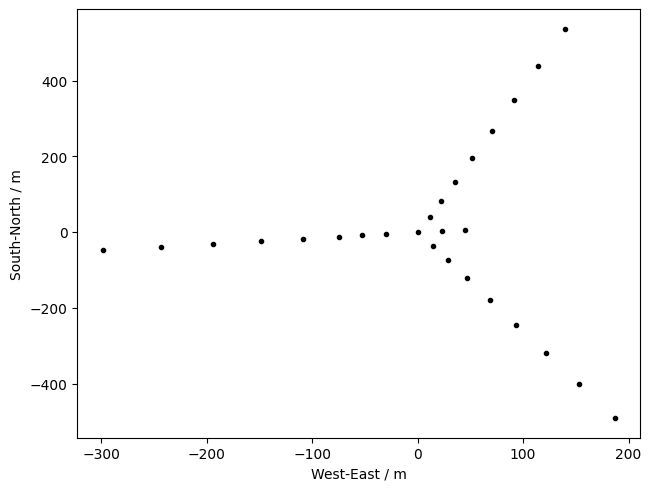

In [260]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(eje3[:,0], eje3[:,1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

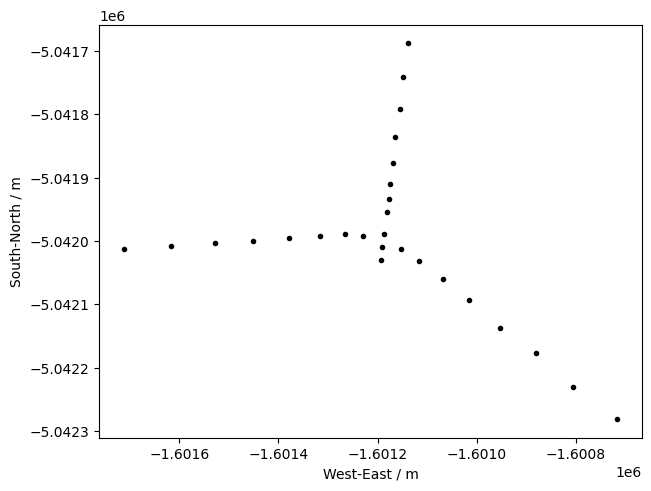

In [299]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(localVLA[:,0], localVLA[:,1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [262]:
vvvv = new_base(eje3)

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

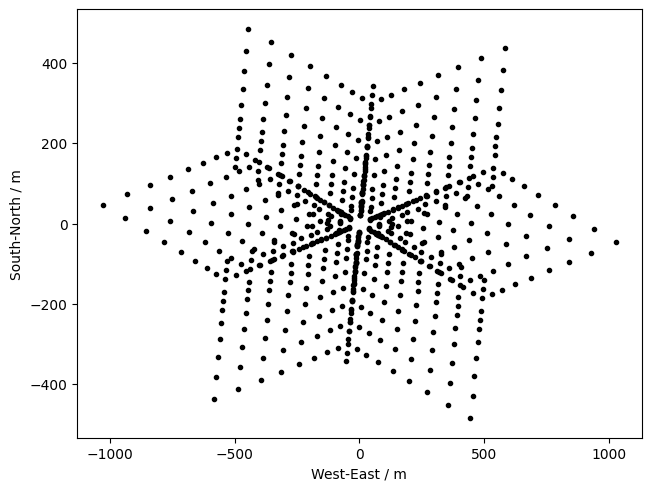

In [263]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(vvvv[:,1], vvvv[:,0], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

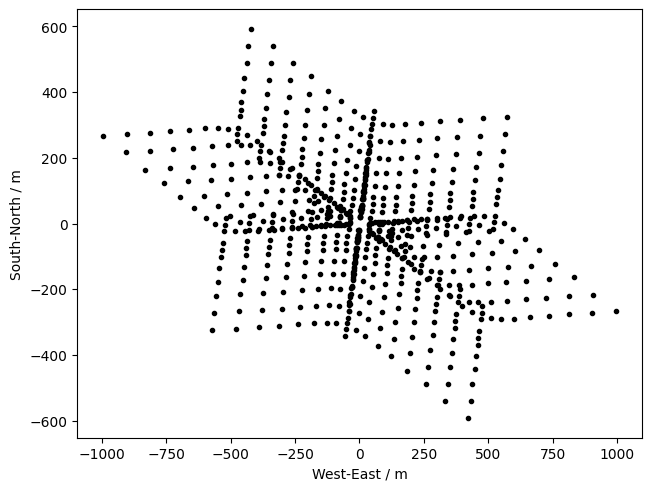

In [265]:
vvvv = new_base(localVLA)
fig, ax = plt.subplots(layout='constrained')

ax.plot(vvvv[:,0], vvvv[:,1], '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [23]:
# 12 horas observacion dec:45
HA, dec = h(6,-35, 120)
#UV_coverageEJ3 = coverage(baselines(eje3), HA, dec)/wavelength
N_UV_coverageEJ3 = new_cover(new_base(eje3), HA, dec)
N_UV_coverageEJ3N = new_cover(new_base(localVLA), HA, dec)

Text(0, 0.5, 'v (lambda)')

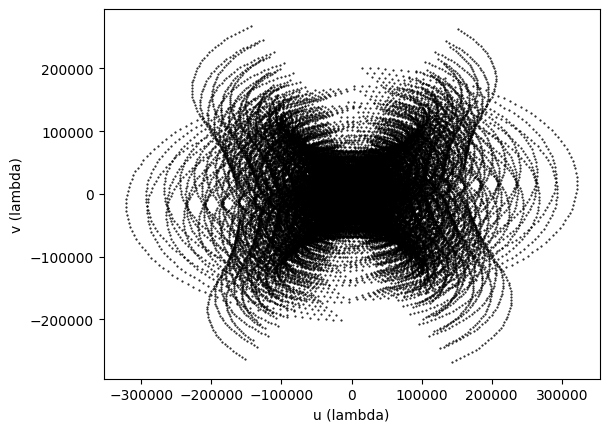

In [301]:
fig, ax = plt.subplots()

ax.scatter(N_UV_coverageEJ3[:, 0],N_UV_coverageEJ3[:,1], c="black", marker=".", s=1)
ax.set_xlabel('u (lambda)')
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

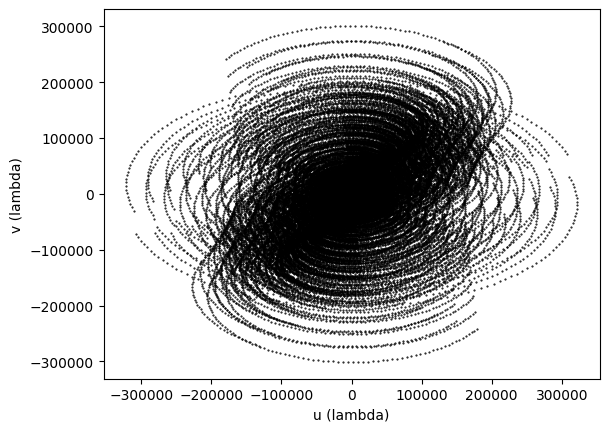

In [302]:
fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ3N[:, 0],N_UV_coverageEJ3N[:,1], c="black", marker=".",s=1)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [24]:
samplingEJ3,_,_=grid_sampling(900,np.max(np.abs(baselines(eje3))), N_UV_coverageEJ3)
new_samplingEJ3,uvgrid ,_ =grid_sampling(900,np.max(np.abs(new_base(localVLA))), N_UV_coverageEJ3N)

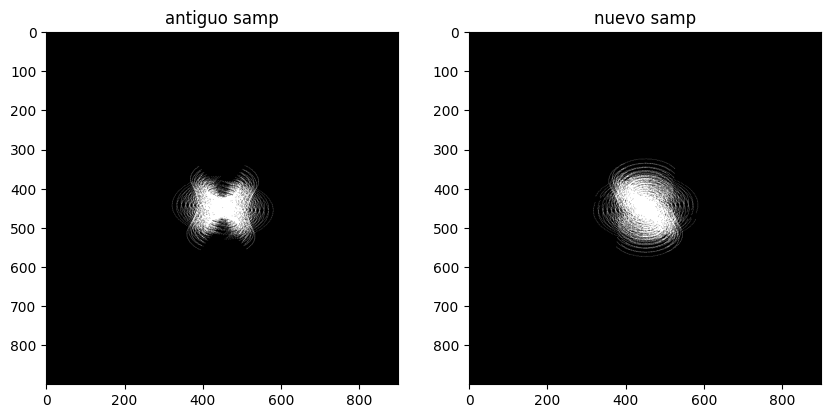

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('antiguo samp')
plt.imshow(samplingEJ3.real, cmap='gray')
plt.subplot(122)
plt.title('nuevo samp')
plt.imshow(new_samplingEJ3.real, cmap='gray')

In [307]:
obs_EJ3 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ3)))
new_obs_EJ3 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ3)))

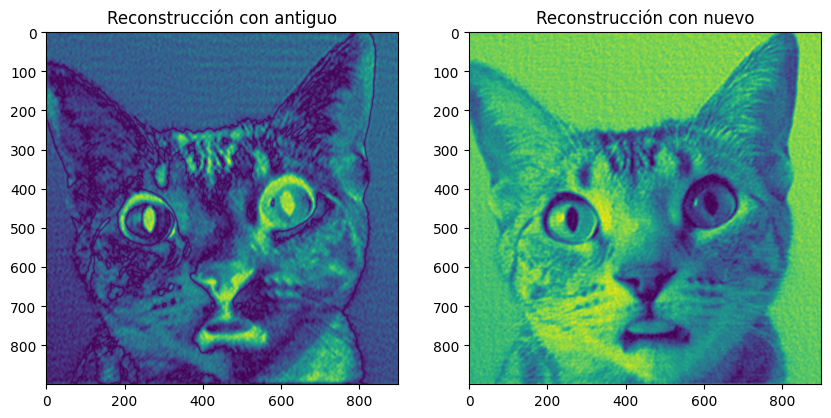

In [308]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ3)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ3)